In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale,  StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split


from scipy.stats import boxcox

import os

pd.set_option('display.max_columns', None)
# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def replace_low_freq(df, threshold=100, replacement='other'):
    s = df.stack()
    c = s.value_counts()
    m = pd.Series(replacement, c.index[c <= threshold])
    return s.replace(m).unstack()

In [3]:
def findSkewedColumns(columns, df, thresholdPercent = 80, displayValueCounts = False):
    skewedColumns = []
    for col in columns:
        valueCounts = (100*df[col].value_counts(normalize=True)).to_dict()
        if(displayValueCounts):
            print(col)
            print(valueCounts)
        abovethreshold = list(filter(lambda x:x>thresholdPercent, valueCounts.values()))
        if(len(abovethreshold)>0):
            skewedColumns.append(col)
    return skewedColumns

In [4]:
pricingInfo = pd.read_csv('train.csv')
originalCol = pricingInfo.columns
pricingInfo.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,Gas

In [5]:
pricingInfo.shape

(1460, 81)

In [6]:
pricingInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Inspecting and handling null values

In [7]:
# inspect null values
nulls = round(100*(pricingInfo.isnull().sum()/len(pricingInfo.index)), 2).sort_values(ascending=False)
nulls = nulls[nulls.values>0]
nulls

PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
FireplaceQu     47.26
LotFrontage     17.74
GarageCond       5.55
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
BsmtExposure     2.60
BsmtFinType2     2.60
BsmtFinType1     2.53
BsmtCond         2.53
BsmtQual         2.53
MasVnrArea       0.55
MasVnrType       0.55
Electrical       0.07
dtype: float64

In [8]:
# droping columns with >80% of null values and id column
pricingInfo.drop(['Id','PoolQC', 'Alley', 'Fence', 'MiscFeature'], axis=1, inplace=True)

#### investigate FireplaceQu

In [9]:
pricingInfo.FireplaceQu.value_counts(normalize=True, dropna=False) 

NaN    0.472603
Gd     0.260274
TA     0.214384
Fa     0.022603
Ex     0.016438
Po     0.013699
Name: FireplaceQu, dtype: float64

In [10]:
pricingInfo.FireplaceQu.fillna('NoFirePlace', inplace=True)

In [11]:
pricingInfo.FireplaceQu.value_counts(normalize=True, dropna=False) 

NoFirePlace    0.472603
Gd             0.260274
TA             0.214384
Fa             0.022603
Ex             0.016438
Po             0.013699
Name: FireplaceQu, dtype: float64

#### investigate BsmtCond

In [12]:
pricingInfo.BsmtCond.value_counts(normalize=True, dropna=False) 

TA     0.897945
Gd     0.044521
Fa     0.030822
NaN    0.025342
Po     0.001370
Name: BsmtCond, dtype: float64

In [13]:
pricingInfo.BsmtCond.fillna('NoBasement', inplace=True)

In [14]:
pricingInfo.BsmtCond.value_counts(normalize=True, dropna=False) 

TA            0.897945
Gd            0.044521
Fa            0.030822
NoBasement    0.025342
Po            0.001370
Name: BsmtCond, dtype: float64

### Observation
For all the below columns null value means missing feature in the house. so instead of dropping, we are imputing with a new category

In [15]:
#garage type
pricingInfo.GarageType.fillna('NoGarage', inplace=True)

In [16]:
#garage condition
pricingInfo.GarageCond.fillna('NoGarage', inplace=True)

In [17]:
#garage finish
pricingInfo.GarageFinish.fillna('NoGarage', inplace=True)

In [18]:
#garage quality
pricingInfo.GarageQual.fillna('NoGarage', inplace=True)

In [19]:
# Rating of basement finished area 
pricingInfo.BsmtFinType1.fillna('NoBasement', inplace=True)

In [20]:
# Rating of basement finished area
pricingInfo.BsmtFinType2.fillna('NoBasement', inplace=True)

In [21]:
#height the of the basement
pricingInfo.BsmtQual.fillna('NoBasement', inplace=True)

In [22]:
#basement exposure
pricingInfo.BsmtExposure.fillna('NoBasement', inplace=True)

In [23]:
pricingInfo.MasVnrType.value_counts(dropna=False)

None       864
BrkFace    445
Stone      128
BrkCmn      15
NaN          8
Name: MasVnrType, dtype: int64

In [24]:
## investigate relation between nulls of masvnrType and masvnrares
pricingInfo.loc[((pricingInfo.MasVnrType.isnull()) & (pricingInfo.MasVnrArea.notna()))]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


#### Observation
MasVnrArea is null only if MasVnrType is null. which means whem MasVnrArea is not available. hence area can be set to 0.

In [25]:
#masvnrtype condition
# pricingInfo.MasVnrType.fillna(pricingInfo.MasVnrType.mode()[0], inplace=True)
pricingInfo.MasVnrType.fillna('novener', inplace=True)
pricingInfo.MasVnrArea.fillna(0, inplace=True)

In [26]:
nulls = round(100*(pricingInfo.isnull().sum()/len(pricingInfo.index)), 2).sort_values(ascending=False)
nulls = nulls[nulls.values>0]
nulls

LotFrontage    17.74
GarageYrBlt     5.55
Electrical      0.07
dtype: float64

In [27]:
pricingInfo.GarageYrBlt.describe()

count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

In [28]:
pricingInfo.Electrical.value_counts(dropna=False)

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: Electrical, dtype: int64

#### Observation
1 missing value. Hence can be dropped. 

In [29]:
print(pricingInfo.shape)
pricingInfo = pricingInfo[pricingInfo.Electrical.notna()]
print(pricingInfo.shape)

(1460, 76)
(1459, 76)


In [30]:
#LotFrontage    
pricingInfo.LotFrontage.describe(percentiles=[.1,.25,.3, .5,.75, .8,.9,.95,.97, .98 ,1])

count    1200.000000
mean       70.047500
std        24.294727
min        21.000000
10%        43.900000
25%        59.000000
30%        60.000000
50%        69.000000
75%        80.000000
80%        85.000000
90%        96.000000
95%       107.000000
97%       120.000000
98%       124.080000
100%      313.000000
max       313.000000
Name: LotFrontage, dtype: float64

#### Observation
Mean and meadian are approximately same hence any one can be used to impute. We are using mean as of now

In [31]:
pricingInfo.LotFrontage.fillna(pricingInfo.LotFrontage.mean(), inplace=True)

In [32]:
#investigate nulls again
nulls = round(100*(pricingInfo.isnull().sum()/len(pricingInfo.index)), 2).sort_values(ascending=False)
nulls = nulls[nulls.values>0]
nulls

GarageYrBlt    5.55
dtype: float64

GarageYrBlt handled later during conversion

### Creating derived variables from year variables

In [33]:
import datetime
def convertToAge(value , columnName):
    now = datetime.datetime.now()
    year = now.year
    if np.isnan(value):
        return -1
    else:
        return year - round(value)


In [34]:
# 1. YearBuilt
pricingInfo['PropertyAge'] = pricingInfo.YearBuilt.apply(convertToAge, args=['YearBuilt'])
pricingInfo.loc[:, ['PropertyAge', 'YearBuilt']].head() 

,PropertyAge,YearBuilt
0,17,2003
1,44,1976
2,19,2001
3,105,1915
4,20,2000


In [35]:
# 2. YearRemodAdd
pricingInfo['YearsRemodel'] = pricingInfo.YearRemodAdd.apply(convertToAge, args=['YearRemodAdd'])
pricingInfo.loc[:, ['YearsRemodel', 'YearRemodAdd']].head()

,YearsRemodel,YearRemodAdd
0,17,2003
1,44,1976
2,18,2002
3,50,1970
4,20,2000


In [36]:
# 3.Yr Sold
pricingInfo['YearsSinceLastSold'] = pricingInfo.YrSold.apply(convertToAge, args=['YrSold'])
pricingInfo.loc[:, ['YearsSinceLastSold', 'YrSold']].head()

,YearsSinceLastSold,YrSold
0,12,2008
1,13,2007
2,12,2008
3,14,2006
4,12,2008


In [37]:
# 4. GarageYrBlt
pricingInfo['YearsSinceGarage'] = pricingInfo.GarageYrBlt.apply(convertToAge, args=['GarageYrBlt'])
pricingInfo.loc[:, ['YearsSinceGarage', 'GarageYrBlt']].head() 

,YearsSinceGarage,GarageYrBlt
0,17,2003.0
1,44,1976.0
2,19,2001.0
3,22,1998.0
4,20,2000.0


## Exploratory data analysis

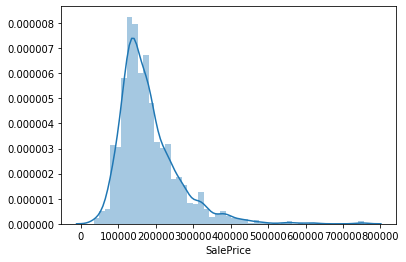

In [38]:
sns.distplot(pricingInfo.SalePrice)

#### Observation
We see that the distribution has outliers and is skewed. We will try to convert this to gausian form.

In [39]:
# double check for -ve values as boxcox will fail for -ve values
pricingInfo[pricingInfo.SalePrice<=0]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,PropertyAge,YearsRemodel,YearsSinceLastSold,YearsSinceGarage


In [40]:
from numpy import exp

# power transform - logarithmic transformation
data = boxcox(pricingInfo.SalePrice, 0)
pricingInfo.SalePrice = data
# pricingInfo.SalePrice = np.log(pricingInfo.SalePrice)

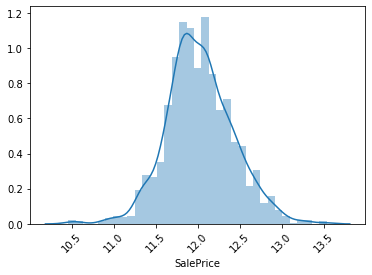

In [41]:
plt.xticks(rotation=45)
sns.distplot(pricingInfo.SalePrice)

### Observation
Log transformation converts the target variable to normal form. 

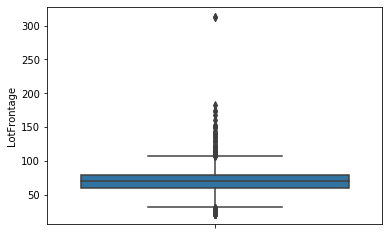

In [42]:
sns.boxplot(x='LotFrontage', data=pricingInfo, orient='v' )

#### Observation
The standard street size linked is between 50 and 100
Contains some outliers. Need to be handled.

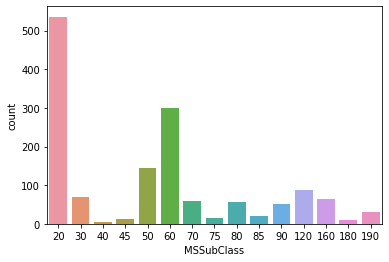

In [43]:
#Type of dwellings in sale
sns.countplot(pricingInfo.MSSubClass)

#### Observation. 
Most of the houses for sale are 1 storey wtih 1946 or above model or 2 story wtih 1946 or above model

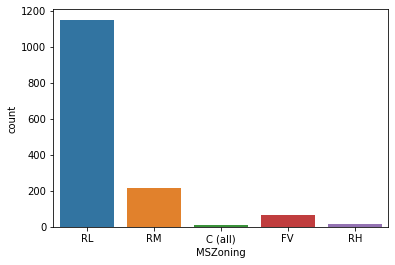

In [44]:
#Areas with number of properties for sale. 
sns.countplot(pricingInfo.MSZoning)

#### Observation
Most of the properties up for sale are in residentaiol areas with low density

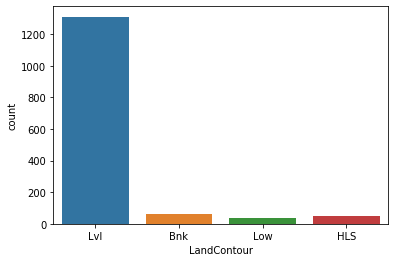

In [45]:
# number of properties for sale based on land conditions
sns.countplot(pricingInfo.LandContour)

In [46]:
pricingInfo.LandContour.value_counts(normalize=True)

Lvl    0.897875
Bnk    0.043180
HLS    0.034270
Low    0.024674
Name: LandContour, dtype: float64

#### Observation
Approx 90% of the values in given data are in level fields. This column is highly skewed.

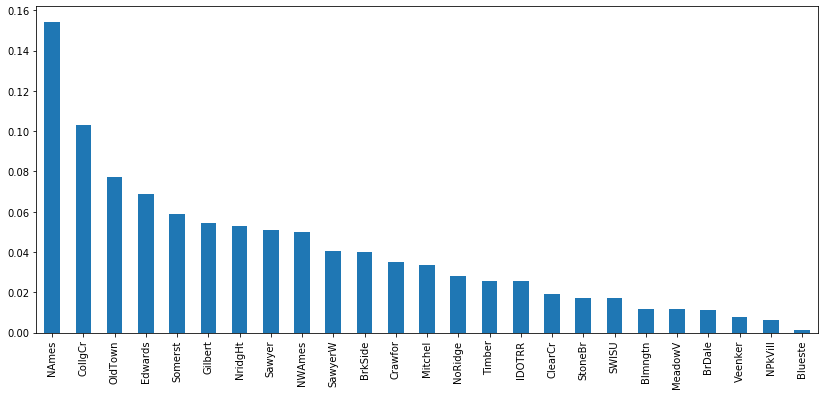

In [47]:
plt.figure(figsize=(14,6))
pricingInfo.Neighborhood.value_counts(normalize=True).plot.bar()

### Observation
North Ames has the highest number of properties up for sale followed by College creek

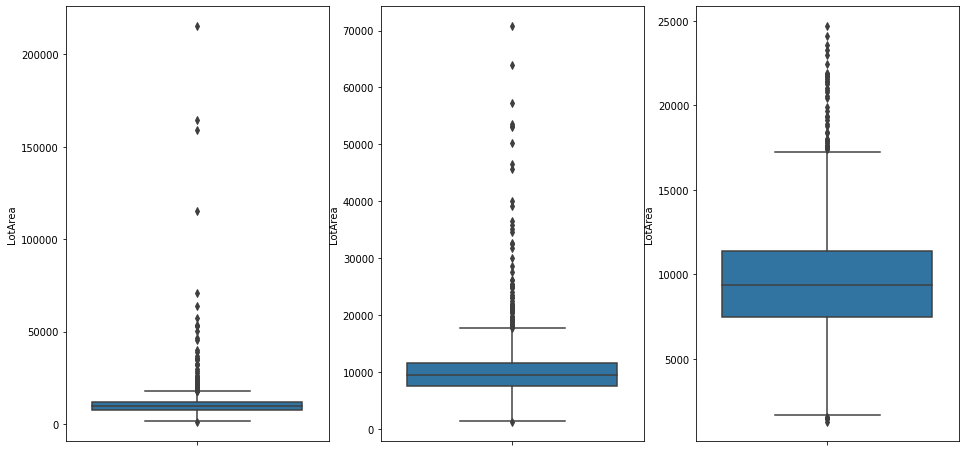

In [48]:
#Lot area distribution
plt.figure(figsize=(16,8))
plt.subplot(1, 3,1)
sns.boxplot(x='LotArea', data=pricingInfo, orient='v')

plt.subplot(1, 3,2)
sns.boxplot(x='LotArea', data=pricingInfo.loc[pricingInfo.LotArea<100000], orient='v')

plt.subplot(1, 3, 3)
sns.boxplot(x='LotArea', data=pricingInfo.loc[pricingInfo.LotArea<25000], orient='v')

In [49]:
pricingInfo.LotArea.describe(percentiles=[.1,.25,.3, .5,.75, .8,.9,.95,.97, .98 ,1])

count      1459.000000
mean      10517.363948
std        9984.666267
min        1300.000000
10%        5000.000000
25%        7549.000000
30%        8063.400000
50%        9477.000000
75%       11603.000000
80%       12206.600000
90%       14388.400000
95%       17402.300000
97%       21576.600000
98%       25255.440000
100%     215245.000000
max      215245.000000
Name: LotArea, dtype: float64

#### Observation - 
95% of the properties have lot area less than 20000. We can consider this column for handling outliers, however LotArea is key variable from business point of view

In [50]:
# mapping overallquality, overallcond variable before plotting for better readability
overallQualityValues = {
    1:"Very_Poor", 
    2:"Poor", 
    3:"Fair", 
    4:"Below_Average", 
    5:"Average", 
    6:"Above_Average", 
    7:"Good", 
    8:"Very_Good", 
    9:"Excellent", 
    10:"Very_Excellent",
}
pricingInfo[['OverallQual']] = pricingInfo[['OverallQual']].apply(lambda x: x.map(overallQualityValues))
pricingInfo[['OverallCond']] = pricingInfo[['OverallCond']].apply(lambda x: x.map(overallQualityValues))
pricingInfo.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,PropertyAge,YearsRemodel,YearsSinceLastSold,YearsSinceGarage
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Good,Average,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NoFirePlace,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,12.247694,17,17,12,17
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Above_Average,Very_Good,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,12.109011,44,44,13,44
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Good,Average,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,12.317167,19,18,12,19
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Good,Average,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,11.849398,105,50,14,22
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Very_Good,Average,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,12.429216,20,20,12,20


Text(0, 0.5, 'Percentage')

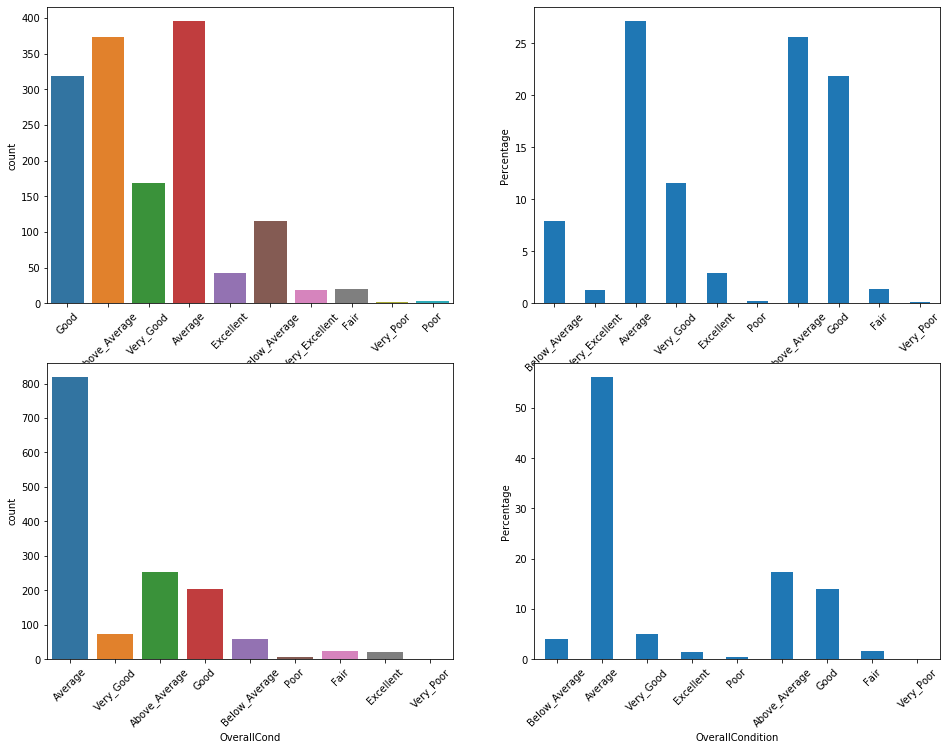

In [51]:
#Quality and condition of available properties
plt.figure(figsize=(16,12))

plt.subplot(2, 2,1)
plt.xticks(rotation=45)
sns.countplot(pricingInfo.OverallQual)

plt.subplot(2, 2,2)
(100*pricingInfo.OverallQual.value_counts(normalize=True, sort=False)).plot.bar()
plt.xticks(rotation=45)
plt.xlabel('OverallQuality')
plt.ylabel('Percentage')

plt.subplot(2, 2,3)
plt.xticks(rotation=45)
sns.countplot(pricingInfo.OverallCond)


plt.subplot(2, 2, 4)
(100*pricingInfo.OverallCond.value_counts(normalize=True, sort=False)).plot.bar()
plt.xticks(rotation=45)
plt.xlabel('OverallCondition')
plt.ylabel('Percentage')


### Observation
Most of the houses have been built using average or above average quality material. Hence the condition of the house is accordingly. These columns are correlated. 

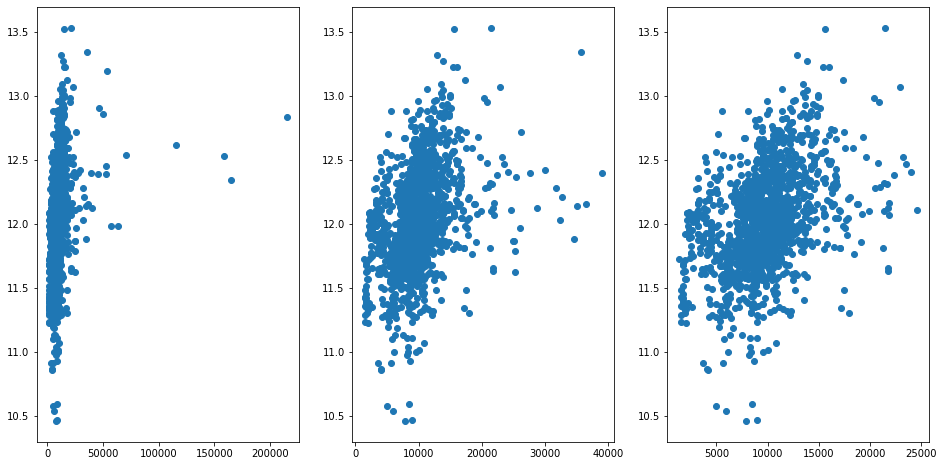

In [52]:
# area vs price
#Lot area distribution
plt.figure(figsize=(16,8))
plt.subplot(1, 3,1)
plt.scatter(x='LotArea', y='SalePrice', data=pricingInfo)

plt.subplot(1, 3,2)
plt.scatter(x='LotArea', y='SalePrice', data=pricingInfo.loc[pricingInfo.LotArea<40000])

plt.subplot(1, 3, 3)
plt.scatter(x='LotArea', y='SalePrice', data=pricingInfo.loc[pricingInfo.LotArea<25000])

### Observation
Increasing lot area increases the price of the property in general

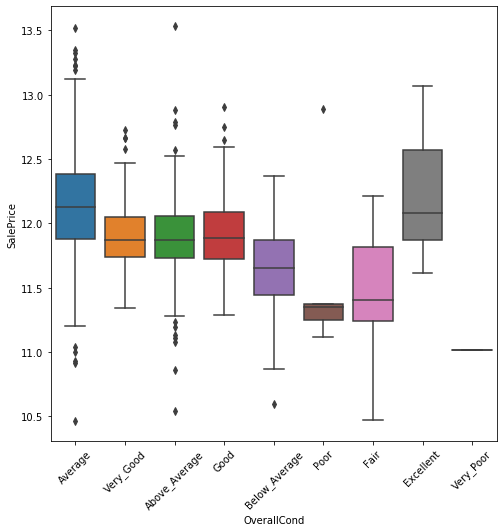

In [53]:
#OVerall condition vs pricing distribution
plt.figure(figsize=(8,8))
plt.xticks(rotation=45)
sns.boxplot(x='OverallCond',y='SalePrice',data=pricingInfo, orient='v')

#### Observation
median values of properties rated average and excellent are almost same. The properties rated Above average, good, very good have lower median and high values. Also, we noticed above that most of the properties are average. Hence this graphs seems inevitable.

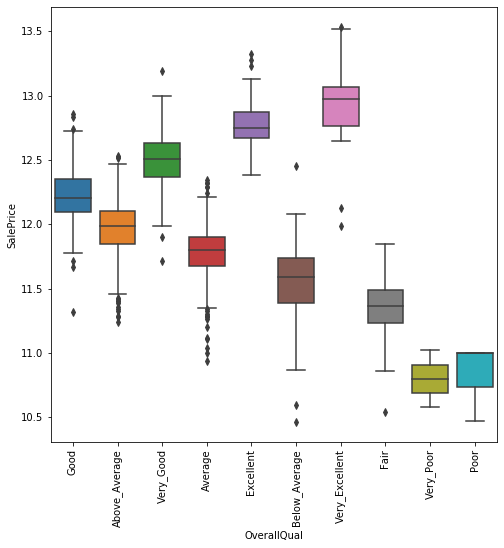

In [54]:
plt.figure(figsize=(8,8))
plt.xticks(rotation=90)
sns.boxplot(x='OverallQual',y='SalePrice',data=pricingInfo, orient='v')

#### Observation
We see the pricing of the properties keep increasing in a consistent manner as the overall quality of the property improves. Properties with excellent material and finish quality are higher sold

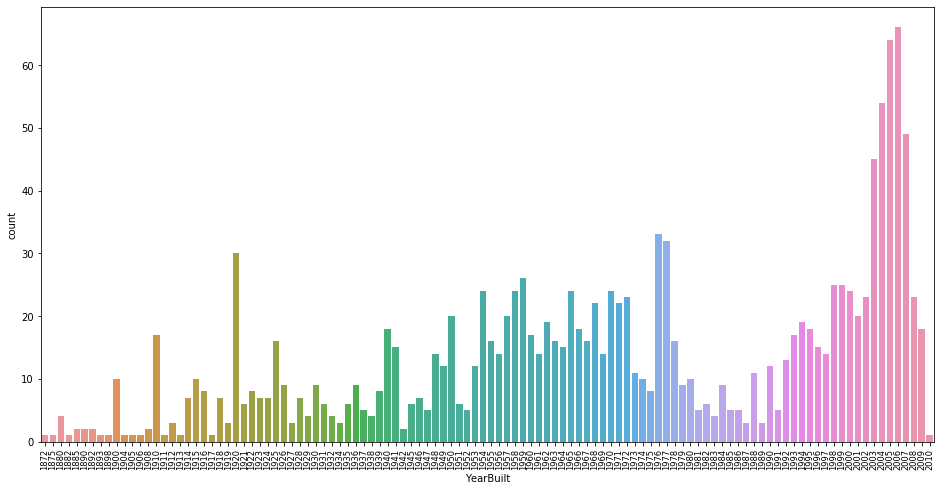

In [55]:
# number of properties by year
plt.figure(figsize=(16,8))
plt.xticks(rotation=90,fontweight='light',fontsize='small')
sns.countplot(pricingInfo.YearBuilt)

### Observation
Most of the properties available for sale are built from 1990-2010.

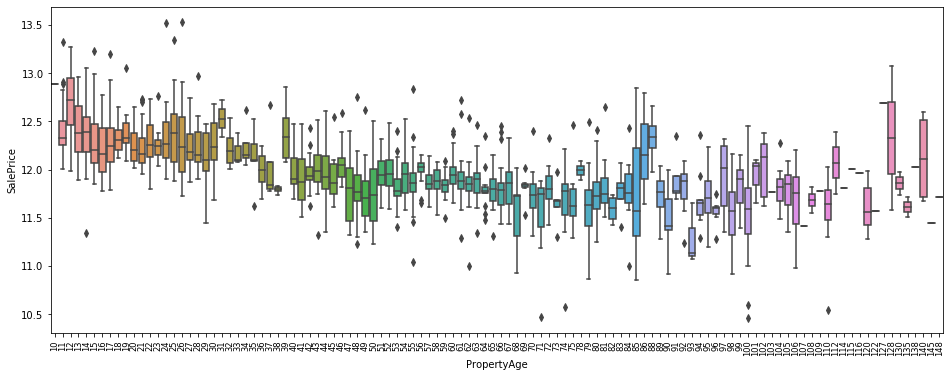

In [56]:
# number of properties by year
plt.figure(figsize=(16,6))
plt.xticks(rotation=90,fontweight='light',fontsize='small')
sns.boxplot(x='PropertyAge',y='SalePrice',data=pricingInfo, orient='v')

### Observation
The lesser the age of property i.e. if the property is a newer construction, it is will generally have higher price. 

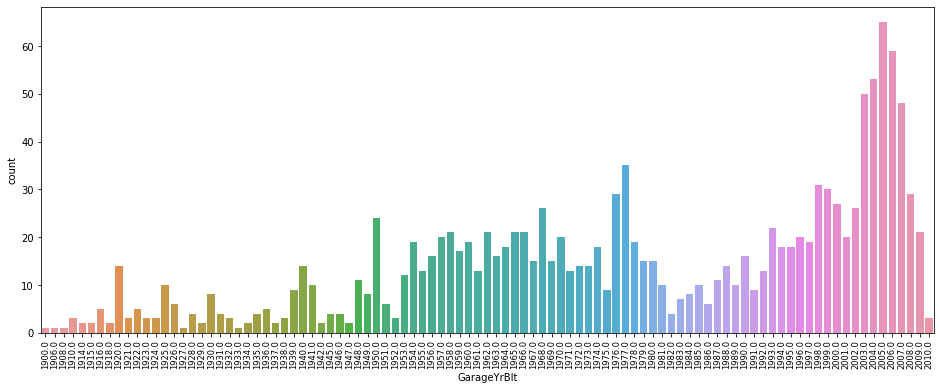

In [57]:
# number of properties by garage year built. 
plt.figure(figsize=(16,6))
plt.xticks(rotation=90,fontweight='light',fontsize='small')
sns.countplot(pricingInfo.GarageYrBlt)

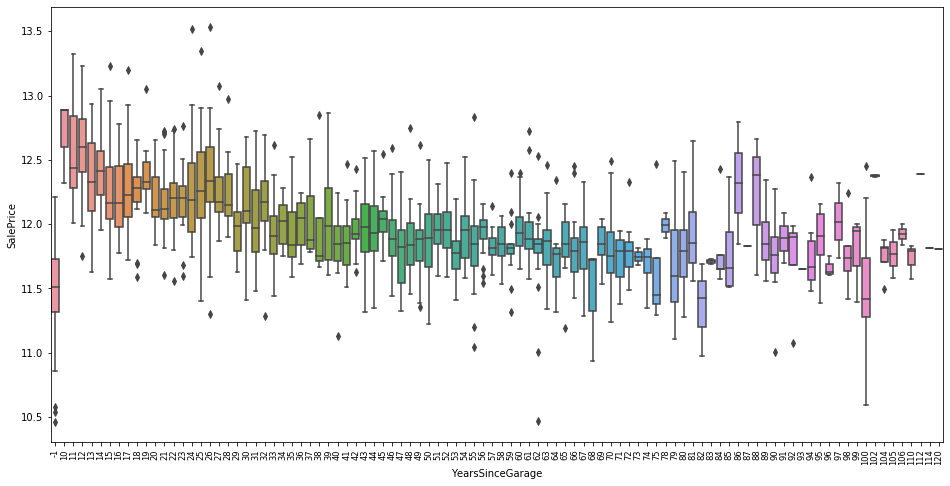

In [58]:
# price with garage age
plt.figure(figsize=(16,8))
plt.xticks(rotation=90,fontweight='light',fontsize='small')
sns.boxplot(x='YearsSinceGarage',y='SalePrice',data=pricingInfo, orient='v')

#### Observation
Pricing benefit for the recently built garages just like the newly build properties. We also see that there are a lot of properties without garage and these have been sold at very low prices.

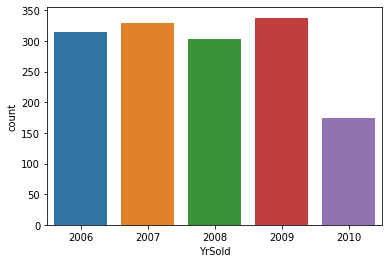

In [59]:
# properties sold by year
# plt.figure(figsize=(8,8))
sns.countplot(x='YrSold', data=pricingInfo)

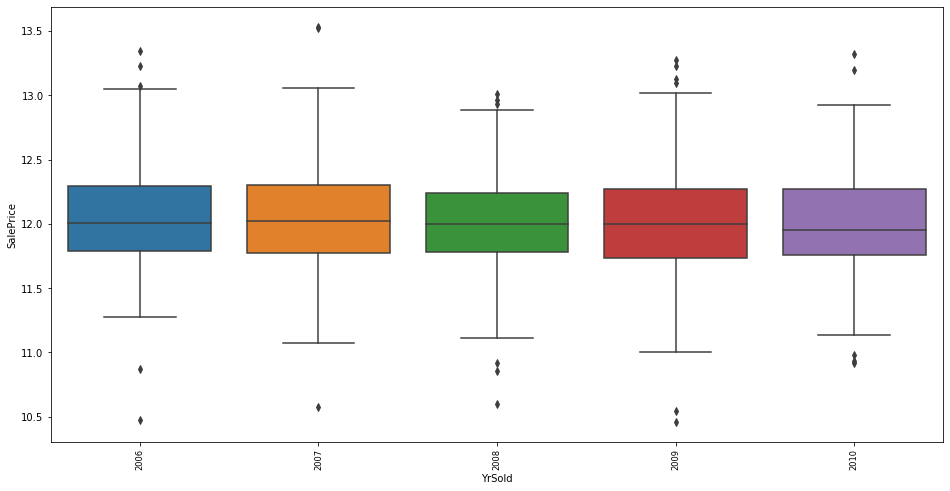

In [60]:
# year sold vs price
plt.figure(figsize=(16,8))
plt.xticks(rotation=90,fontweight='light',fontsize='small')
sns.boxplot(x='YrSold',y='SalePrice',data=pricingInfo, orient='v')

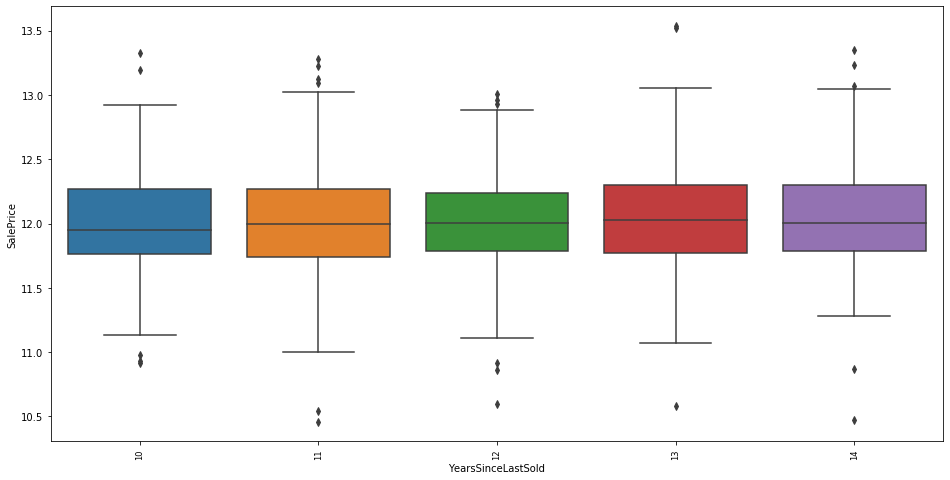

In [61]:
# year sold vs price
plt.figure(figsize=(16,8))
plt.xticks(rotation=90,fontweight='light',fontsize='small')
sns.boxplot(x='YearsSinceLastSold',y='SalePrice',data=pricingInfo, orient='v')

#### Observation
Market has been stable through years.
- Sales have been consitent
- Price ranges have also been in similar range with slight difference. 
- Since this is not impacting sales we may drop this column

In [62]:
# inspect MasVnrArea
pricingInfo.MasVnrArea.describe(percentiles=[.1,.25,.3, .5,.75, .8,.9,.95,.97, .98,.99 ,1])

count    1459.000000
mean      103.187800
std       180.773158
min         0.000000
10%         0.000000
25%         0.000000
30%         0.000000
50%         0.000000
75%       164.500000
80%       205.400000
90%       335.000000
95%       456.000000
97%       573.780000
98%       650.840000
99%       791.360000
100%     1600.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

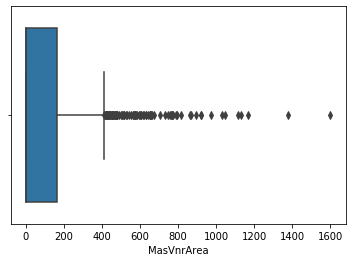

In [63]:
sns.boxplot(x='MasVnrArea', data=pricingInfo)

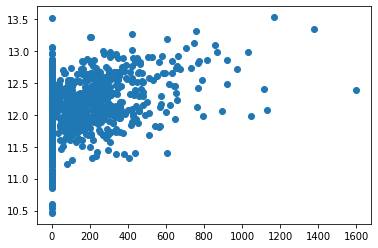

In [64]:
plt.scatter(x='MasVnrArea', y='SalePrice', data=pricingInfo)

#### Observation
Masonry veneer area does not seem to impact pricing. 

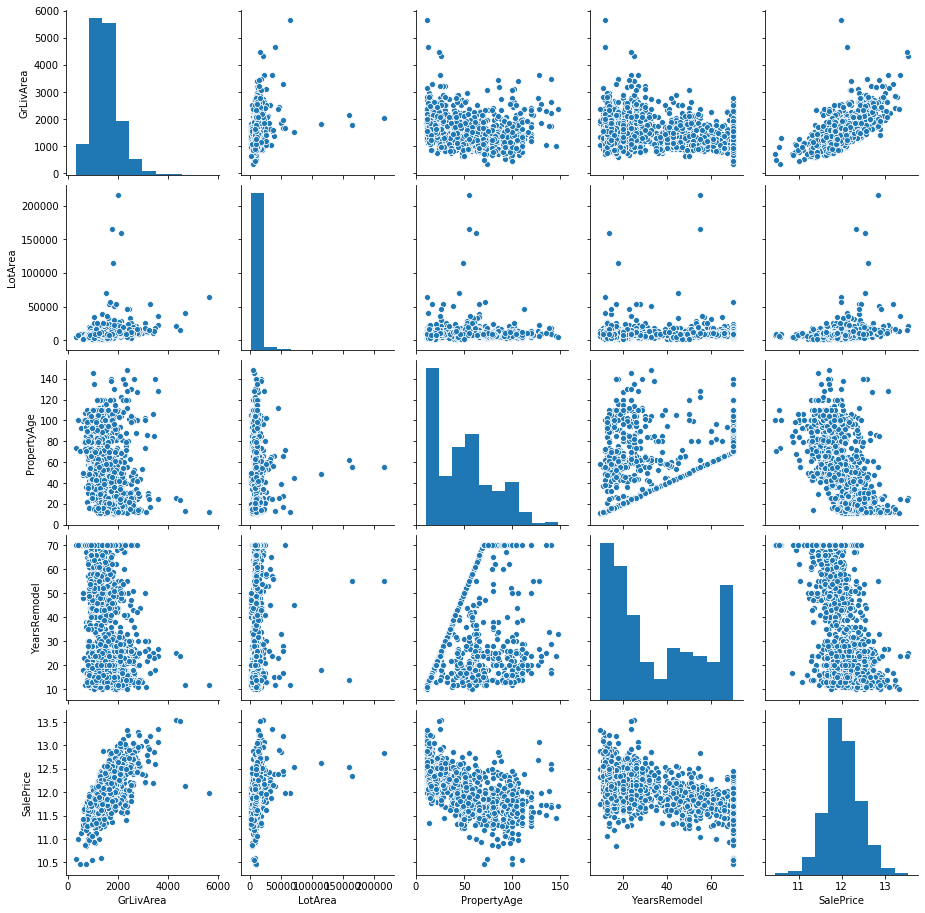

In [65]:
#relation betwewn few numerical and target variable
sns.pairplot(pricingInfo[['GrLivArea', 'LotArea', 'PropertyAge', 'YearsRemodel', 'SalePrice']]);

### Few key observations
- recently remodelled properties have slightly high prices.
- Straight line on the graph b/w property age and year remodel is for the properties that have not been remodelled.
- Higher the grliving area higher the price. 

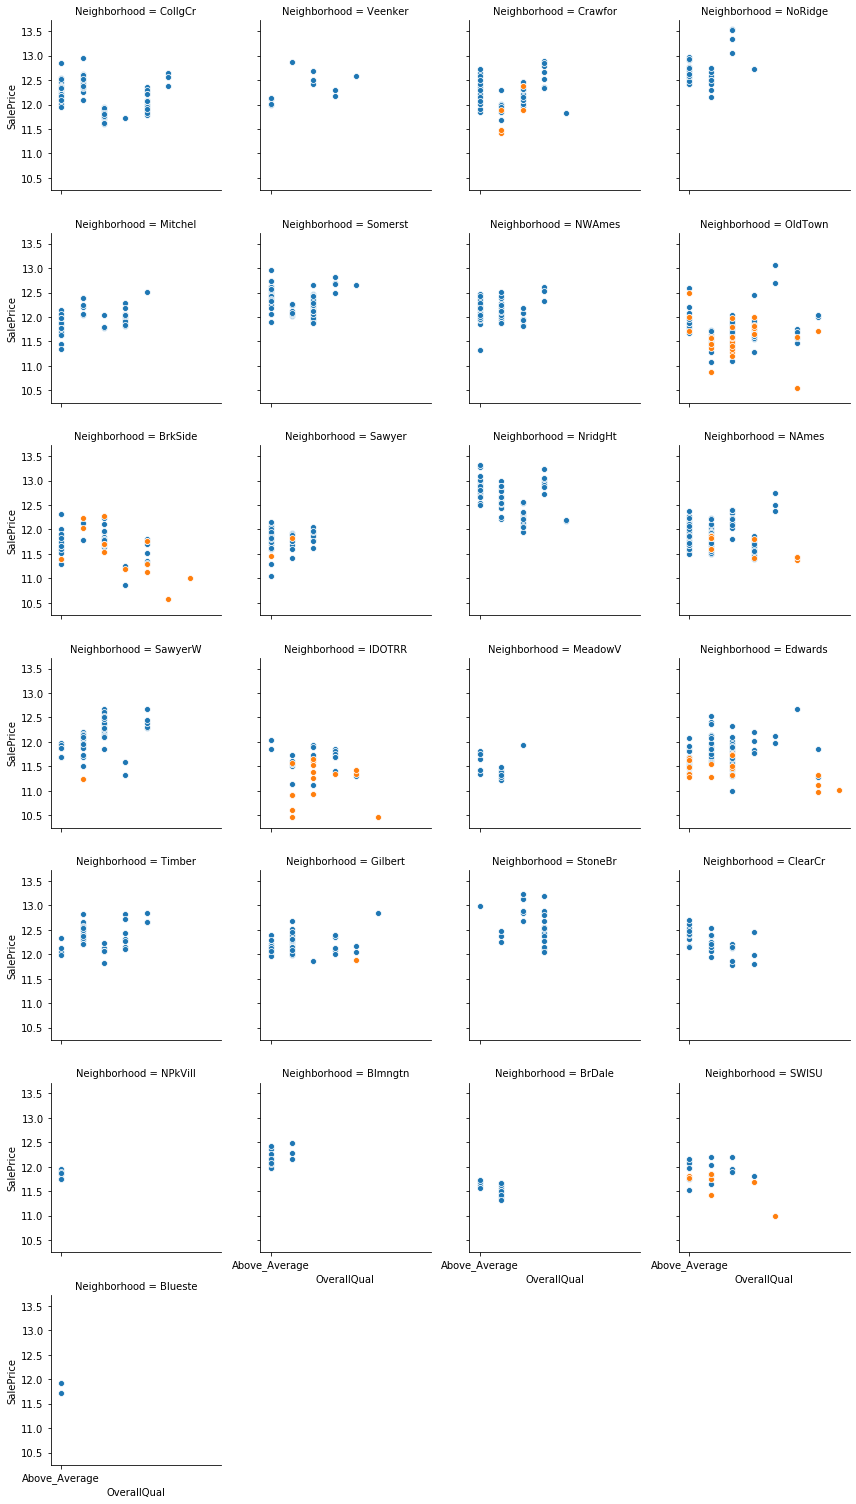

In [66]:
#relation between neighbourhood, central ac, and sale price. 
AreaCentralAirPrice = sns.FacetGrid(data=pricingInfo, col='Neighborhood', hue='CentralAir', col_wrap=4)
AreaCentralAirPrice.map(sns.scatterplot, 'OverallQual', 'SalePrice');

#### Observations
OldTown, BrkSide, Edwards SWISU , IDOTRR seem to have maximum houses without central air conditioning and these tend to have lower prices

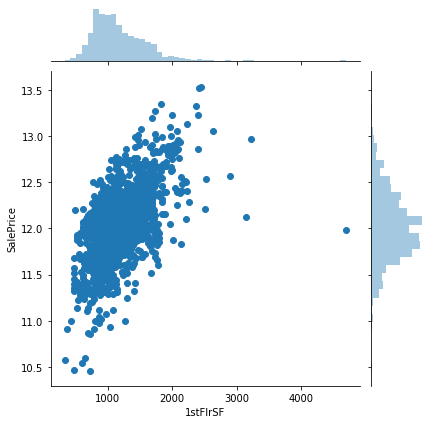

In [67]:
## relationship between 1st floor are and sale price
sns.jointplot(x=pricingInfo['1stFlrSF'], y=pricingInfo['SalePrice']);

#### Observation
As we might expect, with increase in surface area price is increasing. Outliers are present though. 

In [68]:
# these columns have been converted to derived parameters hence can be dropped
pricingInfo.drop(['YearBuilt', 'YearRemodAdd' , 'YrSold' ,'GarageYrBlt'], axis=1, inplace=True)

### Dropping skewed columns

In [69]:
pricingInfo.SaleCondition.value_counts(normalize=True)

Normal     0.820425
Partial    0.085675
Abnorml    0.069225
Family     0.013708
Alloca     0.008225
AdjLand    0.002742
Name: SaleCondition, dtype: float64

In [70]:
pricingInfo.SaleType.value_counts(normalize=True)

WD       0.867718
New      0.083619
COD      0.029472
ConLD    0.006169
ConLw    0.003427
ConLI    0.003427
CWD      0.002742
Oth      0.002056
Con      0.001371
Name: SaleType, dtype: float64

In [71]:
pricingInfo.PavedDrive.value_counts(normalize=True)

Y    0.917752
N    0.061686
P    0.020562
Name: PavedDrive, dtype: float64

In [72]:
pricingInfo.shape

(1459, 76)

In [73]:
## logic to identify any skewed columns
columns = pricingInfo.select_dtypes('object').columns
columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [74]:
len(columns)

41

In [75]:
#skewed columns where 1 value is in over 80% rows. 
skewedColumns = findSkewedColumns(columns, pricingInfo, 80, False)
skewedColumns

['Street',
 'LandContour',
 'Utilities',
 'LandSlope',
 'Condition1',
 'Condition2',
 'BldgType',
 'RoofMatl',
 'ExterCond',
 'BsmtCond',
 'BsmtFinType2',
 'Heating',
 'CentralAir',
 'Electrical',
 'Functional',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [76]:
print('Dropping these columns', skewedColumns)
pricingInfo.drop(skewedColumns, inplace =True, axis=1)

Dropping these columns ['Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


In [77]:
pricingInfo.shape

(1459, 56)

### Observation 
Around 20 skewed categorical columns have been removed.

In [78]:
# identify possible categorical variables from integer types
intColumns = pricingInfo.select_dtypes(include=['int64', 'float64']).columns
print('possible categorical columns \n')
cat = []
for col in intColumns:
    if len(pricingInfo[col].value_counts().index)<=10:
        print(col)
        print(pricingInfo[col].value_counts())
        print()
        cat.append(col)

possible categorical columns 

BsmtFullBath
0    855
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64

BsmtHalfBath
0    1377
1      80
2       2
Name: BsmtHalfBath, dtype: int64

FullBath
2    767
1    650
3     33
0      9
Name: FullBath, dtype: int64

HalfBath
0    913
1    534
2     12
Name: HalfBath, dtype: int64

BedroomAbvGr
3    803
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

KitchenAbvGr
1    1391
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64

Fireplaces
0    689
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

GarageCars
2    823
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64

PoolArea
0      1452
738       1
648       1
576       1
555       1
519       1
512       1
480       1
Name: PoolArea, dtype: int64

YearsSinceLastSold
11    338
13    329
14    314
12    303
10    175
Name: YearsSinceLastSold, dtype: int64



In [79]:
# inspecting MiscVal column
pricingInfo.MiscVal.value_counts(normalize=True)

0        0.964359
400      0.007539
500      0.005483
700      0.003427
450      0.002742
2000     0.002742
600      0.002742
1200     0.001371
480      0.001371
1150     0.000685
800      0.000685
15500    0.000685
620      0.000685
3500     0.000685
560      0.000685
2500     0.000685
1300     0.000685
1400     0.000685
350      0.000685
8300     0.000685
54       0.000685
Name: MiscVal, dtype: float64

#### Observation
Columns - PoolArea, KitchenAbvGr ,BsmtHalfBath , MiscVal are highly skewed and hence can be dropped

In [80]:
#convert to categorical
pricingInfo[cat] = pricingInfo[cat].astype('str') 

In [81]:
#convert other int columns to categorical
# this is decided based on data dictionary. and manual inspection above. 
#These columns are perfect candidates for being considered as categorical
catCols = ['MSSubClass', 'TotRmsAbvGrd', 'MoSold']
pricingInfo[catCols] = pricingInfo[catCols].astype('str') #convert to categorical

In [82]:
pricingInfo[cat].dtypes

BsmtFullBath          object
BsmtHalfBath          object
FullBath              object
HalfBath              object
BedroomAbvGr          object
KitchenAbvGr          object
Fireplaces            object
GarageCars            object
PoolArea              object
YearsSinceLastSold    object
dtype: object

In [83]:
#dropping skewed columns
# observed above during conversion to categorical. 
skewedColumns = ['PoolArea', 'KitchenAbvGr', 'BsmtHalfBath', 'MiscVal']
pricingInfo.drop(skewedColumns, axis=1, inplace=True)
cat = [ele for ele in cat if ele not in skewedColumns] 
cat

['BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'Fireplaces',
 'GarageCars',
 'YearsSinceLastSold']

In [84]:
# revisit the columns
for c in cat:
    print(pricingInfo[c].value_counts(normalize=False))
    print()

0    855
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64

2    767
1    650
3     33
0      9
Name: FullBath, dtype: int64

0    913
1    534
2     12
Name: HalfBath, dtype: int64

3    803
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

0    689
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

2    823
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64

11    338
13    329
14    314
12    303
10    175
Name: YearsSinceLastSold, dtype: int64



## Handling outliers

In [85]:
### function to find the possible outliers for each column
def getOutlierCount(df, col):
    mean = df[col].mean()
    std = df[col].std()
    print("Upper outliers: ", df[col][(df[col] > mean + 3 * std)].count())
    print("Lower outliers: ", df[col][(df[col] < mean - 3 * std)].count())

### function to remove outliers on upper range of the variable. 
def removeUpperOutlier(df, col):
    mean = df[col].mean()
    std = df[col].std()
    newdf= df[(df[col] < mean + 3 * std)]
    return newdf

In [86]:
### handling outliers
intColumns = pricingInfo.select_dtypes(include=['int64', 'float64']).columns
columnsForOutliers = [c for c in intColumns if c not in cat and c not in skewedColumns]
print(columnsForOutliers)

['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'SalePrice', 'PropertyAge', 'YearsRemodel', 'YearsSinceGarage']


In [87]:
skewedColumns = findSkewedColumns(columnsForOutliers,pricingInfo)
skewedColumns

['BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']

In [88]:
pricingInfo.EnclosedPorch.value_counts(normalize=True)

0      0.857437
112    0.010281
96     0.004112
120    0.003427
144    0.003427
         ...   
174    0.000685
177    0.000685
183    0.000685
189    0.000685
552    0.000685
Name: EnclosedPorch, Length: 120, dtype: float64

In [89]:
#drop skewedColumns
# pricingInfo.drop(skewedColumns, axis=1, inplace=True)

# columns now left for outlier treatment
columnsForOutliers = [c for c in columnsForOutliers if c not in skewedColumns]
columnsForOutliers

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'SalePrice',
 'PropertyAge',
 'YearsRemodel',
 'YearsSinceGarage']

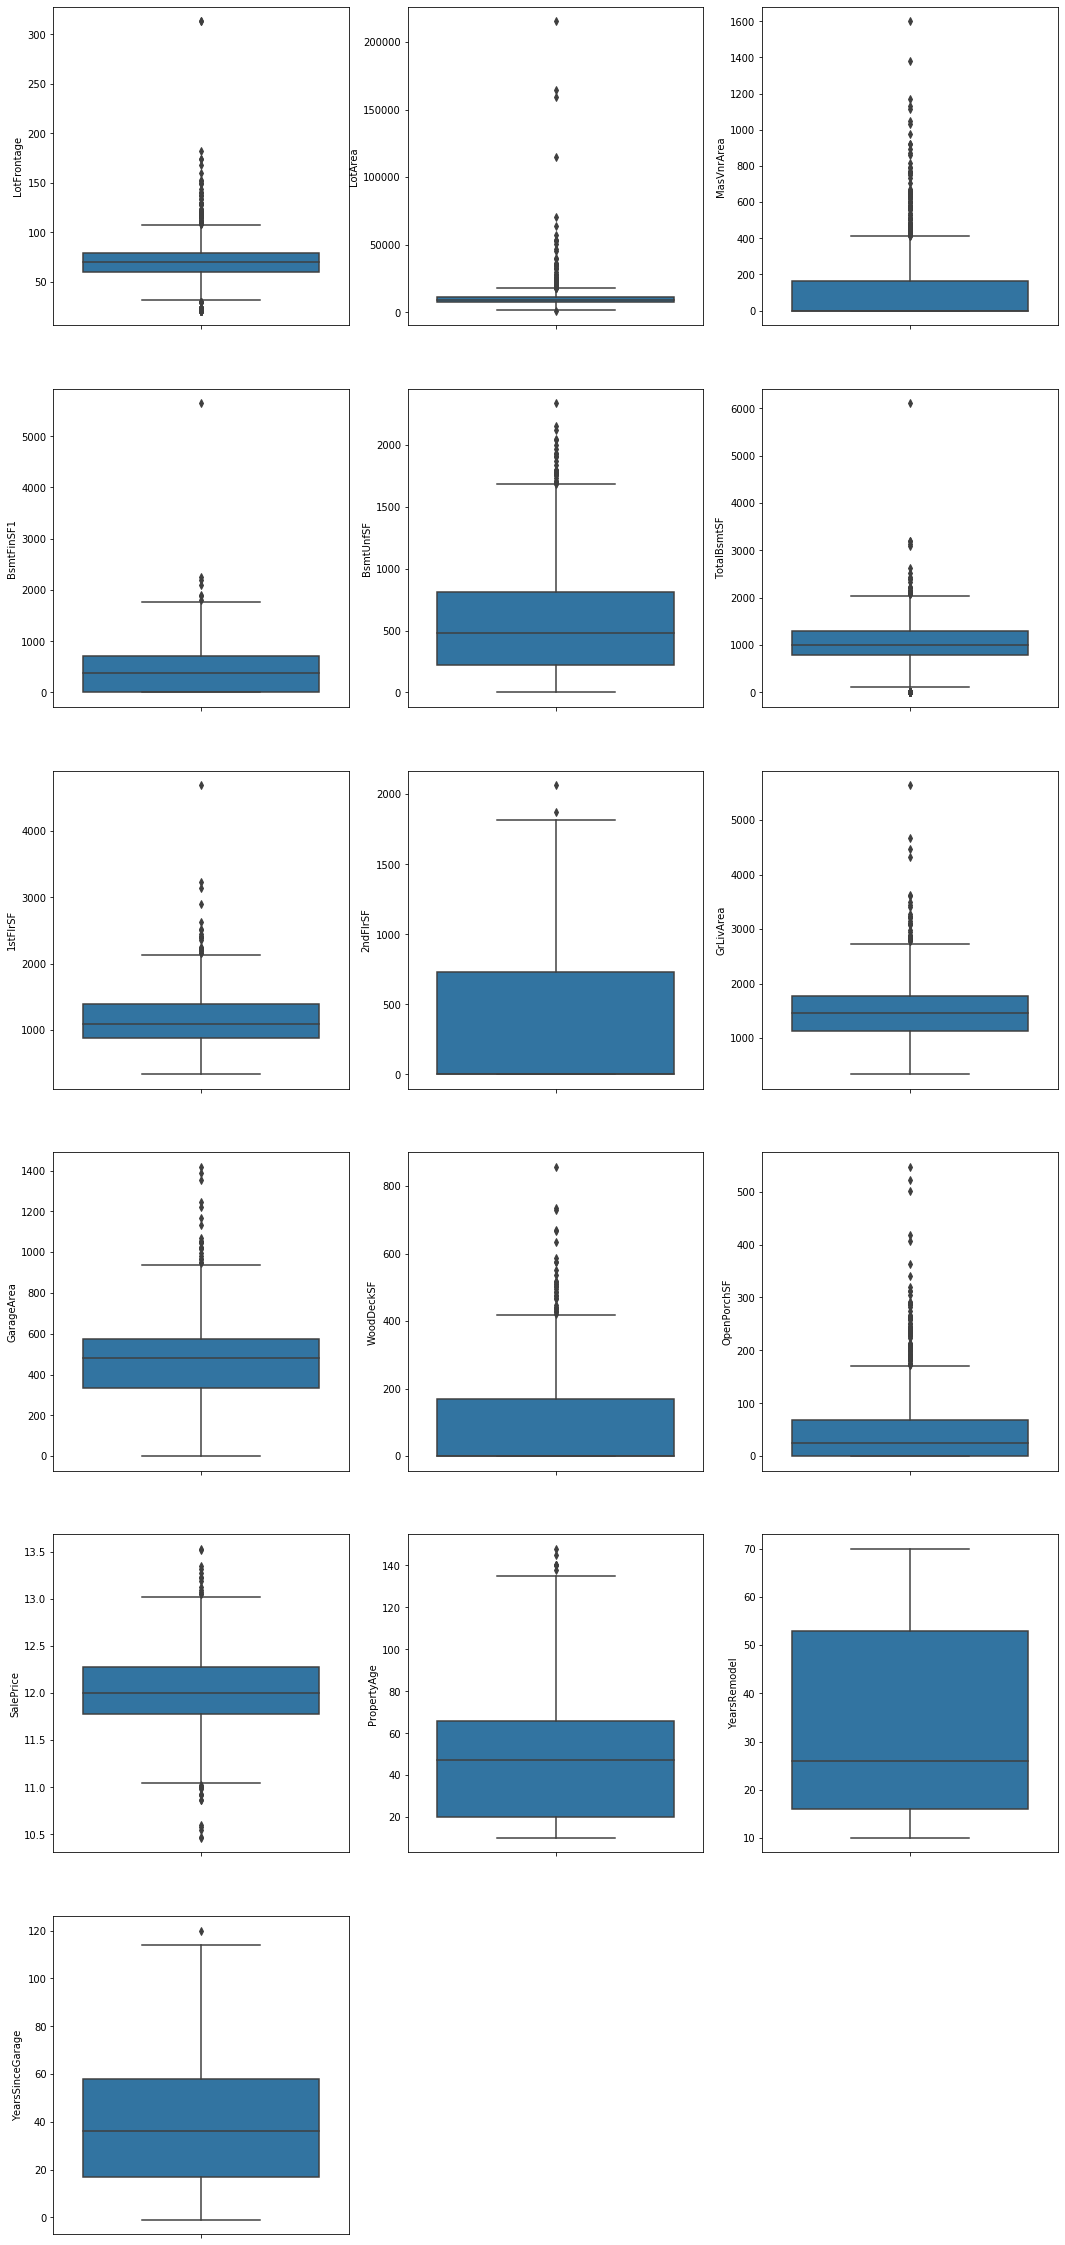

In [90]:
plt.figure(figsize=(18,48))
i=1
for col in columnsForOutliers:
    plt.subplot(7, 3, i)
    sns.boxplot(x=col, data=pricingInfo, orient='v')
    i=i+1

#### Observation 
Following columns might need outlier treatment
- LotArea
- TotalBsmtSF
- GrLivArea
- BsmtFinSF1
- OpenPorchSF

In [91]:
getOutlierCount(pricingInfo, 'LotArea')

Upper outliers:  13
Lower outliers:  0


In [92]:
#LotArea
pricingInfo = removeUpperOutlier(pricingInfo, 'LotArea')
pricingInfo.shape

(1446, 52)

In [93]:
getOutlierCount(pricingInfo, 'TotalBsmtSF')

Upper outliers:  10
Lower outliers:  0


In [94]:
#TotalBsmtSF
pricingInfo = removeUpperOutlier(pricingInfo, 'TotalBsmtSF')
pricingInfo.shape

(1436, 52)

In [95]:
getOutlierCount(pricingInfo, 'GrLivArea')

Upper outliers:  13
Lower outliers:  0


In [96]:
#TotalBsmtSF
pricingInfo = removeUpperOutlier(pricingInfo, 'GrLivArea')
pricingInfo.shape

(1423, 52)

In [97]:
pricingInfo['1stFlrSF'].describe(percentiles=[.1,.25,.3, .5,.75, .8,.9,.95,.97, .98 ,1])

count    1423.000000
mean     1141.773015
std       352.359912
min       334.000000
10%       756.000000
25%       876.000000
30%       912.000000
50%      1077.000000
75%      1362.500000
80%      1453.600000
90%      1650.200000
95%      1775.500000
97%      1877.440000
98%      2000.000000
100%     2898.000000
max      2898.000000
Name: 1stFlrSF, dtype: float64

In [98]:
getOutlierCount(pricingInfo, '1stFlrSF')

Upper outliers:  7
Lower outliers:  0


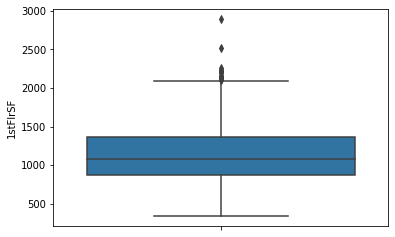

In [99]:
#1stFlrSF
sns.boxplot(x='1stFlrSF', data=pricingInfo, orient='v')

In [100]:
# % age of non zero values.
len(pricingInfo.loc[pricingInfo.WoodDeckSF>0].index)/len(pricingInfo.index)

0.47224174279690795

In [101]:
pricingInfo.shape

(1423, 52)

In [102]:
pricingInfo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1423 entries, 0 to 1459
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MSSubClass          1423 non-null   object 
 1   MSZoning            1423 non-null   object 
 2   LotFrontage         1423 non-null   float64
 3   LotArea             1423 non-null   int64  
 4   LotShape            1423 non-null   object 
 5   LotConfig           1423 non-null   object 
 6   Neighborhood        1423 non-null   object 
 7   HouseStyle          1423 non-null   object 
 8   OverallQual         1423 non-null   object 
 9   OverallCond         1423 non-null   object 
 10  RoofStyle           1423 non-null   object 
 11  Exterior1st         1423 non-null   object 
 12  Exterior2nd         1423 non-null   object 
 13  MasVnrType          1423 non-null   object 
 14  MasVnrArea          1423 non-null   float64
 15  ExterQual           1423 non-null   object 
 16  Founda

### Create dummy variables

In [103]:
catColumns = pricingInfo.select_dtypes('object')
catColumns

,MSSubClass,MSZoning,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,HeatingQC,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,MoSold,YearsSinceLastSold
0,60,RL,Reg,Inside,CollgCr,2Story,Good,Average,Gable,VinylSd,VinylSd,BrkFace,Gd,PConc,Gd,No,GLQ,Ex,1,2,1,3,Gd,8,0,NoFirePlace,Attchd,RFn,2,2,12
1,20,RL,Reg,FR2,Veenker,1Story,Above_Average,Very_Good,Gable,MetalSd,MetalSd,None,TA,CBlock,Gd,Gd,ALQ,Ex,0,2,0,3,TA,6,1,TA,Attchd,RFn,2,5,13
2,60,RL,IR1,Inside,CollgCr,2Story,Good,Average,Gable,VinylSd,VinylSd,BrkFace,Gd,PConc,Gd,Mn,GLQ,Ex,1,2,1,3,Gd,6,1,TA,Attchd,RFn,2,9,12
3,70,RL,IR1,Corner,Crawfor,2Story,Good,Average,Gable,Wd Sdng,Wd Shng,None,TA,BrkTil,TA,No,ALQ,Gd,1,1,0,3,Gd,7,1,Gd,Detchd,Unf,3,2,14
4,60,RL,IR1,FR2,NoRidge,2Story,Very_Good,Average,Gable,VinylSd,VinylSd,BrkFace,Gd,PConc,Gd,Av,GLQ,Ex,1,2,1,4,Gd,9,1,TA,Attchd,RFn,3,12,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,Reg,Inside,Gilbert,2Story,Above_Average,Average,Gable,VinylSd,VinylSd,None,TA,PConc,Gd,No,Unf,Ex,0,2,1,3,TA,7,1,TA,Attchd,RFn,2,8,13
1456,20,RL,Reg,Inside,NWAmes,1Story,Above_Average,Above_Average,Gable,Plywood,Plywood,Stone,TA,CBlock,Gd,No,ALQ,TA,1,2,0,3,TA,7,2,TA,Attchd,Unf,2,2,10
1457,70,RL,Reg,Inside,Crawfor,2Story,Good,Excellent,Gable,CemntBd,CmentBd,None,Ex,Stone,TA,No,GLQ,Ex,0,2,0,4,Gd,9,2,Gd,Attchd,RFn,1,5,10
1458,20,RL,Reg,Inside,NAmes,1Story,Average,Above_Average,Hip,MetalSd,MetalSd,None,TA,CBlock,TA,Mn,GLQ,Gd,1,1,0,2,Gd,5,0,NoFirePlace,Attchd,Unf,1,4,10


In [104]:
dummyDf = pd.get_dummies(catColumns, drop_first=True, prefix= catColumns.columns)
dummyDf

,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_Average,OverallQual_Below_Average,OverallQual_Excellent,OverallQual_Fair,OverallQual_Good,OverallQual_Poor,OverallQual_Very_Excellent,OverallQual_Very_Good,OverallQual_Very_Poor,OverallCond_Average,OverallCond_Below_Average,OverallCond_Excellent,OverallCond_Fair,OverallCond_Good,OverallCond_Poor,OverallCond_Very_Good,OverallCond_Very_Poor,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_novener,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NoBasement,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBasement,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBasement,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,BsmtFullBath_1,BsmtFullBath_2,BsmtFullBath_3,FullBath_1,FullBath_2,FullBath_3,HalfBath_1,HalfBath_2,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,TotRmsAbvGrd_11,TotRmsAbvGrd_12,TotRmsAbvGrd_2,TotRmsAbvGrd_3,TotRmsAbvGrd_4,TotRmsAbvGrd_5,TotRmsAbvGrd_6,TotRmsAbvGrd_7,TotRmsAbvGrd_8,TotRmsAbvGrd_9,Fireplaces_1,Fireplaces_2,Fireplaces_3,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFirePlace,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YearsSinceLastSold_11,YearsSinceLastSold_12,YearsSinceLastSold_13,YearsSinceLastSold_14
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0

In [105]:
pricingInfo2 = pd.concat([pricingInfo, dummyDf], join='inner', axis=1)
pricingInfo2

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MoSold,SalePrice,PropertyAge,YearsRemodel,YearsSinceLastSold,YearsSinceGarage,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_Average,OverallQual_Below_Average,OverallQual_Excellent,OverallQual_Fair,OverallQual_Good,OverallQual_Poor,OverallQual_Very_Excellent,OverallQual_Very_Good,OverallQual_Very_Poor,OverallCond_Average,OverallCond_Below_Average,OverallCond_Excellent,OverallCond_Fair,OverallCond_Good,OverallCond_Poor,OverallCond_Very_Good,OverallCond_Very_Poor,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_novener,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NoBasement,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBasement,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBasement,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,BsmtFullBath_1,BsmtFullBath_2,BsmtFullBath_3,FullBath_1,FullBath_2,FullBath_3,HalfBath_1,HalfBath_2,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,TotRmsAbvGrd_11,TotRmsAbvGrd_12,TotRmsAbvGrd_2,TotRmsAbvGrd_3,TotRmsAbvGrd_4,TotRmsAbvGrd_5,TotRmsAbvGrd_6,TotRmsAbvGrd_7,TotRmsAbvGrd_8,TotRmsAbvGrd_9,Fireplaces_1,Fireplaces_2,Fireplaces_3,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFirePlace,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YearsSinceLastSold_11,YearsSinceLastSold_12,YearsSinceLastSold_13,YearsSinceLastSold_14
0,60,RL,65.0,8450,Reg,Inside,Collg

In [106]:
#drop original variable
pricingInfo2.drop(catColumns.columns.values, axis=1, inplace=True)


In [107]:
pricingInfo2.shape

(1423, 221)

## test train split

In [108]:
y= pricingInfo2['SalePrice']
X = pricingInfo2.drop('SalePrice', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7,test_size = 0.3, random_state=100)

In [109]:
#get columns to scale
scaledColumns = pricingInfo2.select_dtypes(include=['int64', 'float64'])
scaledColumns.drop('SalePrice', axis=1, inplace=True) # we are not scaling the target variable. 

In [110]:
cols = scaledColumns.columns

scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train[cols] = scaler.fit_transform(X_train[cols])

# scaling test data
X_test[cols] = scaler.transform(X_test[cols])
X_test

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PropertyAge,YearsRemodel,YearsSinceGarage,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_Average,OverallQual_Below_Average,OverallQual_Excellent,OverallQual_Fair,OverallQual_Good,OverallQual_Poor,OverallQual_Very_Excellent,OverallQual_Very_Good,OverallQual_Very_Poor,OverallCond_Average,OverallCond_Below_Average,OverallCond_Excellent,OverallCond_Fair,OverallCond_Good,OverallCond_Poor,OverallCond_Very_Good,OverallCond_Very_Poor,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_novener,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NoBasement,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBasement,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBasement,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,BsmtFullBath_1,BsmtFullBath_2,BsmtFullBath_3,FullBath_1,FullBath_2,FullBath_3,HalfBath_1,HalfBath_2,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,TotRmsAbvGrd_11,TotRmsAbvGrd_12,TotRmsAbvGrd_2,TotRmsAbvGrd_3,TotRmsAbvGrd_4,TotRmsAbvGrd_5,TotRmsAbvGrd_6,TotRmsAbvGrd_7,TotRmsAbvGrd_8,TotRmsAbvGrd_9,Fireplaces_1,Fireplaces_2,Fireplaces_3,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFirePlace,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YearsSinceLastSold_11,YearsSinceLastSold_12,YearsSinceLastSold_13,YearsSinceLastSold_14
909,3.886200,0.734773,-0.585700,-1.010093,-0.293232,0.408918,-0.741812,-1.120967,0.995513,-0.107267,0.025924,-0.371151,-0.448290,-0.320333,-0.368805,-0.111662,-0.264598,-1.121875,-0.973728,-0.932069,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,

### Ridge Regression

In [111]:
# Running RFE with the output number of the variable equal to 80
rdg =  LinearRegression()
rdg.fit(X_train, y_train)

rfe_ridge = RFE(rdg, 80)             # running RFE
rfe_ridge = rfe_ridge.fit(X_train, y_train)

In [112]:
selected_cols_ridge = rfe_ridge.get_support(1) #the most important features
col_ridge = X_train.columns[selected_cols_ridge]
print(col_ridge)

Index(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'PropertyAge', 'MSSubClass_160', 'MSSubClass_20', 'MSSubClass_45',
       'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSZoning_FV',
       'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Neighborhood_Crawfor',
       'Neighborhood_MeadowV', 'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_StoneBr', 'HouseStyle_2.5Fin', 'HouseStyle_SFoyer',
       'OverallQual_Excellent', 'OverallQual_Fair', 'OverallQual_Poor',
       'OverallQual_Very_Excellent', 'OverallQual_Very_Good',
       'OverallQual_Very_Poor', 'OverallCond_Average',
       'OverallCond_Below_Average', 'OverallCond_Excellent',
       'OverallCond_Fair', 'OverallCond_Good', 'OverallCond_Very_Good',
       'OverallCond_Very_Poor', 'RoofStyle_Mansard', 'Exterior1st_BrkComm',
       'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_ImStucc',
       'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior2nd_CBlock',
   

In [113]:
alpha_ridge = np.linspace(0.01,10, 1000)
params_ridge = {'alpha':alpha_ridge}

X_train_ridge_rfe = X_train[col_ridge]
ridge = Ridge()

# cross validation
ridge_folds = 5
model_cv_ridge = GridSearchCV(estimator = ridge, 
                        param_grid = params_ridge, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = ridge_folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv_ridge.fit(X_train_ridge_rfe, y_train) 


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:   55.1s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([ 0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09,
        0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,  0.18,
        0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,  0....
        9.46,  9.47,  9.48,  9.49,  9.5 ,  9.51,  9.52,  9.53,  9.54,
        9.55,  9.56,  9.57,  9.58,  9.59,  9.6 ,  9.61,  9.62,  9.63,
        9.64,  9.65,  9.66,  9.67,  9.68,  9.69,  9.7 ,  9.71,  9.72,
        9.73,  9.74,  9.75,  9.76,  9.77,  9.78,  9.79,  9.8 ,  9.81,
        9.82,  9.83,  9.84,  9.85,  9.86,  9.87,  9.88,  9.89,  9.9 ,
        9.91,  9.92,  9.93,  9.94,  9.95,  9.96,  9.97,  9.98,  9.99,
       10.  ])},
             pre_dispatch='2*n

In [114]:
cv_results_ridge = pd.DataFrame(model_cv_ridge.cv_results_)
# cv_results = cv_results[cv_results['param_alpha']<=10]
cv_results_ridge

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.004133,0.001603,0.001738,0.000640,0.01,{'alpha': 0.01},-0.089457,-0.086750,-0.086124,-0.084758,-0.087206,-0.086859,0.001539,240,-0.076340,-0.076197,-0.076415,-0.076669,-0.076287,-0.076381,0.000160
1,0.003807,0.000919,0.001312,0.000643,0.02,{'alpha': 0.02},-0.089494,-0.086706,-0.086102,-0.084750,-0.086934,-0.086797,0.001548,209,-0.076349,-0.076217,-0.076431,-0.076680,-0.076313,-0.076398,0.000157
2,0.005885,0.001269,0.001772,0.000645,0.03,{'alpha': 0.03},-0.089530,-0.086663,-0.086101,-0.084742,-0.086678,-0.086743,0.001561,182,-0.076359,-0.076238,-0.076448,-0.076691,-0.076338,-0.076415,0.000153
3,0.006186,0.002473,0.004529,0.005108,0.04,{'alpha': 0.04},-0.089565,-0.086628,-0.086101,-0.084735,-0.086435,-0.086693,0.001581,159,-0.076368,-0.076260,-0.076464,-0.076703,-0.076361,-0.076431,0.000151
4,0.007470,0.003499,0.002438,0.000502,0.05,{'alpha': 0.05},-0.089599,-0.086611,-0.086101,-0.084729,-0.086206,-0.086649,0.001605,137,-0.076377,-0.076281,-0.076479,-0.076715,-0.076387,-0.076448,0.000148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.009581,0.004101,0.003001,0.000881,9.96,{'alpha': 9.96},-0.092248,-0.089803,-0.088062,-0.088764,-0.087291,-0.089234,0.001719,996,-0.083646,-0.083505,-0.083570,-0.083844,-0.084070,-0.083727,0.000206
996,0.006854,0.001523,0.003996,0.002268,9.97,{'alpha': 9.97},-0.092251,-0.089806,-0.088066,-0.088768,-0.087297,-0.089238,0.001718,997,-0.083652,-0.083510,-0.083575,-0.083850,-0.084075,-0.083732,0.000206
997,0.004992,0.000681,0.001840,0.000412,9.98,{'alpha': 9.98},-0.092255,-0.089809,-0.088070,-0.088772,-0.087303,-0.089242,0.001718,998,-0.083657,-0.083516,-0.083580,-0.083855,-0.084080,-0.083738,0.000206
998,0.004961,0.000569,0.001958,0.000242,9.99,{'alpha': 9.99},-0.092258,-0.089812,-0.088073,-0.088776,-0.087309,-0.089246,0.001717,999,-0.083663,-0.083521,-0.083585,-0.083861,-0.084085,-0.083743,0.000206


In [115]:
model_cv_ridge.best_estimator_

Ridge(alpha=0.33, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

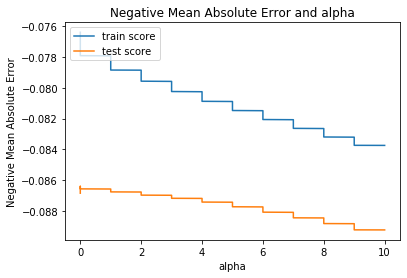

In [116]:
# plotting mean test and train scoes with alpha 
cv_results_ridge['param_alpha'] = cv_results_ridge['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results_ridge['param_alpha'], cv_results_ridge['mean_train_score'])
plt.plot(cv_results_ridge['param_alpha'], cv_results_ridge['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [117]:
alpha_final_ridge = model_cv_ridge.best_estimator_.alpha  #alpha form the best estimator
finalRidge = Ridge(alpha=alpha_final_ridge)

finalRidge.fit(X_train_ridge_rfe, y_train)
finalRidge.coef_

array([ 0.06884836,  0.02265931,  0.07130204,  0.0103816 ,  0.08349516,
       -0.10083694, -0.10704472,  0.05518947,  0.07581771,  0.06959476,
        0.1423095 ,  0.07142877,  0.47989987,  0.31757847,  0.38016561,
        0.33818388,  0.10266098, -0.14384758,  0.10171362, -0.06114176,
        0.16584329, -0.17201735,  0.05705168,  0.11118362, -0.12410078,
       -0.16110727,  0.18820382,  0.06180233, -0.2107202 , -0.06797487,
       -0.09609248,  0.16868055, -0.22287107,  0.06007094,  0.10449281,
       -0.08260563,  0.11404618,  0.11168437,  0.07487796, -0.04053762,
        0.1155337 ,  0.08685788, -0.07942771, -0.04053762, -0.04769582,
       -0.0604504 ,  0.08337328,  0.05957548, -0.0959304 ,  0.02352239,
        0.09689308, -0.04962826,  0.02352239, -0.15956565,  0.16635407,
        0.23165713,  0.06356164,  0.06787721,  0.09253523, -0.11097063,
       -0.08099279, -0.05511527, -0.15801564, -0.08427673, -0.1205626 ,
       -0.12811457,  0.01151675,  0.05616932, -0.02494428, -0.04

In [118]:
#train predict
y_train_pred_ridge = finalRidge.predict(X_train_ridge_rfe)
#test predict
y_pred_ridge = finalRidge.predict(X_test[col_ridge])


print('train r2 score')
print(metrics.r2_score(y_train, y_train_pred_ridge))

print('Test r2 score')
print(metrics.r2_score(y_test, y_pred_ridge))

print('train ridge score')
print(finalRidge.score(X_train_ridge_rfe, y_train_pred_ridge))

print('test ridge score')
print(finalRidge.score(X_test[col_ridge], y_test))


train r2 score
0.9233834143440316
Test r2 score
0.8710509929597355
train ridge score
1.0
test ridge score
0.8710509929597355


In [119]:
ridge_df = pd.DataFrame({"column":X_train_ridge_rfe.columns, 'Coeff': finalRidge.coef_})
ridge_df['absCoeff'] = ridge_df['Coeff'].abs()
ridge_df.sort_values(by='absCoeff', ascending=False)

,column,Coeff,absCoeff
12,MSZoning_FV,0.479900,0.479900
14,MSZoning_RL,0.380166,0.380166
15,MSZoning_RM,0.338184,0.338184
13,MSZoning_RH,0.317578,0.317578
55,BsmtFullBath_3,0.231657,0.231657
...,...,...,...
49,BsmtQual_NoBasement,0.023522,0.023522
1,1stFlrSF,0.022659,0.022659
66,Fireplaces_1,0.011517,0.011517
3,LowQualFinSF,0.010382,0.010382


#### For subjective question 1

In [120]:
alpha_final_ridge2 =  model_cv_ridge.best_estimator_.alpha*2  #alpha form the best estimator * 2
print(alpha_final_ridge2)
finalRidge2 = Ridge(alpha=alpha_final_ridge2)

finalRidge2.fit(X_train_ridge_rfe, y_train)

0.66


Ridge(alpha=0.66, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [121]:
y_pred_ridge2 = finalRidge2.predict(X_test[col_ridge])
y_train_pred_ridge = finalRidge2.predict(X_train_ridge_rfe)
print('train r2 score')
print(metrics.r2_score(y_train, y_train_pred_ridge))

print('Test r2 score')
print(metrics.r2_score(y_test, y_pred_ridge2))

print('train ridge score')
print(finalRidge2.score(X_train[col_ridge], y_train_pred_ridge))

print('test ridge score')
print(finalRidge2.score(X_test[col_ridge], y_test))


train r2 score
0.9223764441317014
Test r2 score
0.8731509099126763
train ridge score
1.0
test ridge score
0.8731509099126763


In [122]:
ridge_df = pd.DataFrame({"column":X_train_ridge_rfe.columns, 'Coeff': finalRidge2.coef_})
ridge_df['absCoeff'] = ridge_df['Coeff'].abs()
ridge_df.sort_values(by='absCoeff', ascending=False)

,column,Coeff,absCoeff
12,MSZoning_FV,0.406076,0.406076
14,MSZoning_RL,0.310278,0.310278
15,MSZoning_RM,0.266681,0.266681
13,MSZoning_RH,0.241294,0.241294
32,OverallCond_Fair,-0.221705,0.221705
...,...,...,...
49,BsmtQual_NoBasement,0.017429,0.017429
52,BsmtFinType1_NoBasement,0.017429,0.017429
66,Fireplaces_1,0.011180,0.011180
3,LowQualFinSF,0.009070,0.009070


## Lasso

In [123]:
# Running RFE with the output number of the variable equal to 10
las =  LinearRegression()
las.fit(X_train, y_train)

rfe_lasso = RFE(las, 80)             # running RFE
rfe_lasso = rfe_lasso.fit(X_train, y_train)

In [124]:
selected_cols = rfe_lasso.get_support(1) #the most important features
col_lasso = X_train.columns[selected_cols]
print(col_lasso)

Index(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'PropertyAge', 'MSSubClass_160', 'MSSubClass_20', 'MSSubClass_45',
       'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSZoning_FV',
       'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Neighborhood_Crawfor',
       'Neighborhood_MeadowV', 'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_StoneBr', 'HouseStyle_2.5Fin', 'HouseStyle_SFoyer',
       'OverallQual_Excellent', 'OverallQual_Fair', 'OverallQual_Poor',
       'OverallQual_Very_Excellent', 'OverallQual_Very_Good',
       'OverallQual_Very_Poor', 'OverallCond_Average',
       'OverallCond_Below_Average', 'OverallCond_Excellent',
       'OverallCond_Fair', 'OverallCond_Good', 'OverallCond_Very_Good',
       'OverallCond_Very_Poor', 'RoofStyle_Mansard', 'Exterior1st_BrkComm',
       'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_ImStucc',
       'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior2nd_CBlock',
   

In [125]:
lasso = Lasso()
X_train_rfe_lasso = X_train[col_lasso]
alpha_lasso = np.linspace(0.0001, 0.001, 1000)
# alpha_lasso = [0.0001, 0.001, 0.01, 0.05, 0.1,  0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,  4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]

params_lasso={'alpha':alpha_lasso}

folds_lasso=5
# cross validation
model_cv_lasso = GridSearchCV(estimator = lasso, 
                        param_grid = params_lasso, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds_lasso, 
                        return_train_score=True,
                        verbose = 1)            

model_cv_lasso.fit(X_train_rfe_lasso, y_train) 

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:  2.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([0.0001    , 0.0001009 , 0.0001018 , 0.0001027 , 0.0001036 ,
       0.0001045 , 0.00010541, 0.00010...
       0.00097838, 0.00097928, 0.00098018, 0.00098108, 0.00098198,
       0.00098288, 0.00098378, 0.00098468, 0.00098559, 0.00098649,
       0.00098739, 0.00098829, 0.00098919, 0.00099009, 0.00099099,
       0.00099189, 0.00099279, 0.00099369, 0.00099459, 0.0009955 ,
       0.0009964 , 0.0009973 , 0.0009982 , 0.0009991 , 0.001     ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [126]:
model_cv_lasso.best_estimator_

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [127]:
cv_results_lasso = pd.DataFrame(model_cv_lasso.cv_results_)
# cv_results = cv_results[cv_results['param_alpha']<=.1]
cv_results_lasso.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.095330,0.016449,0.014569,0.024602,0.0001,{'alpha': 0.0001},-0.090796,-0.086313,-0.085707,-0.085400,-0.085023,-0.086648,0.002117,1,-0.077038,-0.077370,-0.077262,-0.077363,-0.077653,-0.077337,0.000198
1,0.071363,0.011716,0.002126,0.000495,0.000100901,{'alpha': 0.0001009009009009009},-0.090802,-0.086323,-0.085709,-0.085404,-0.085022,-0.086652,0.002118,2,-0.077046,-0.077379,-0.077271,-0.077374,-0.077669,-0.077348,0.000201
2,0.080702,0.022716,0.002783,0.001165,0.000101802,{'alpha': 0.0001018018018018018},-0.090809,-0.086333,-0.085711,-0.085408,-0.085021,-0.086656,0.002120,3,-0.077053,-0.077389,-0.077280,-0.077385,-0.077685,-0.077358,0.000204
3,0.068438,0.020182,0.002419,0.000498,0.000102703,{'alpha': 0.0001027027027027027},-0.090816,-0.086343,-0.085713,-0.085411,-0.085019,-0.086660,0.002122,4,-0.077061,-0.077398,-0.077289,-0.077396,-0.077699,-0.077369,0.000206
4,0.056376,0.003163,0.002431,0.000485,0.000103604,{'alpha': 0.00010360360360360361},-0.090823,-0.086354,-0.085715,-0.085415,-0.085018,-0.086665,0.002124,5,-0.077068,-0.077408,-0.077298,-0.077407,-0.077714,-0.077379,0.000208


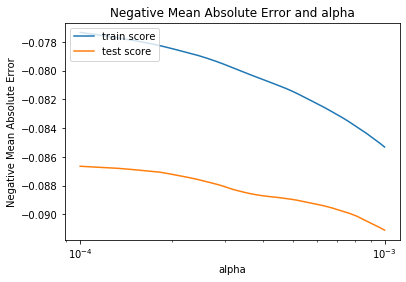

In [128]:
# plotting mean test and train scoes with alpha 
cv_results_lasso['param_alpha'] = cv_results_lasso['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results_lasso['param_alpha'], cv_results_lasso['mean_train_score'])
plt.plot(cv_results_lasso['param_alpha'], cv_results_lasso['mean_test_score'])
plt.xlabel('alpha')
plt.xscale('log')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [129]:
alpha_lasso =model_cv_lasso.best_estimator_.alpha
print(alpha_lasso)

final_lasso = Lasso(alpha=alpha_lasso)
       
final_lasso.fit(X_train_rfe_lasso, y_train) 

0.0001


Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [130]:
y_pred_lasso = final_lasso.predict(X_test[col_lasso])
y_train_pred_lasso = final_lasso.predict(X_train_rfe_lasso)

In [131]:

print('train r2 score')
print(metrics.r2_score(y_train, y_train_pred_lasso))

print('Test r2 score')
print(metrics.r2_score(y_test, y_pred_lasso))

print('train lasso score')
print(final_lasso.score(X_train_rfe_lasso, y_train_pred_lasso))

print('test lasso score')
print(final_lasso.score(X_test[col_lasso], y_test))


train r2 score
0.9226107347077528
Test r2 score
0.8742974432281361
train lasso score
1.0
test lasso score
0.8742974432281361


In [132]:
final_lasso_df = pd.DataFrame({"column":X_train_rfe_lasso.columns, 'Coeff': final_lasso.coef_}).sort_values(by='Coeff')
final_lasso_df['absCoeff'] = final_lasso_df['Coeff'].abs()
final_lasso_df.sort_values(by='absCoeff', ascending=False, inplace=True)
final_lasso_df.head(5)

,column,Coeff,absCoeff
12,MSZoning_FV,0.519937,0.519937
14,MSZoning_RL,0.418567,0.418567
15,MSZoning_RM,0.375174,0.375174
13,MSZoning_RH,0.355997,0.355997
28,OverallQual_Very_Poor,-0.344920,0.344920


#### For subjective question 1

In [133]:
alpha_lasso =model_cv_lasso.best_estimator_.alpha*2
print(alpha_lasso)
final_lasso2 = Lasso(alpha=alpha_lasso)
final_lasso2.fit(X_train_rfe_lasso, y_train) 
final_lasso2.coef_

0.0002


array([ 7.01977802e-02,  0.00000000e+00,  3.93963923e-02,  4.25991122e-03,
        1.16095578e-01, -1.05681965e-01, -1.06601613e-01,  4.50738072e-02,
        3.45460291e-02,  6.95211518e-02,  1.19637757e-01,  5.85567060e-02,
        4.23417690e-01,  2.51016684e-01,  3.26845975e-01,  2.78720838e-01,
        9.50717423e-02, -1.22558481e-01,  9.12492959e-02, -4.98876433e-02,
        1.47859852e-01, -6.12812904e-02,  3.58728129e-02,  1.13194802e-01,
       -1.05453108e-01, -1.53541777e-01,  1.68818588e-01,  6.12992885e-02,
       -2.85490835e-01, -6.81650658e-02, -1.01762612e-01,  1.56206408e-01,
       -2.17049546e-01,  6.07096126e-02,  1.05645668e-01, -0.00000000e+00,
        5.44847555e-02,  0.00000000e+00,  6.83373450e-02, -0.00000000e+00,
        0.00000000e+00,  3.09453535e-02, -3.93588628e-02, -0.00000000e+00,
       -0.00000000e+00, -2.97910494e-03,  4.14334951e-02,  5.89494321e-02,
       -2.50937728e-02, -0.00000000e+00,  9.59836545e-02, -0.00000000e+00,
       -0.00000000e+00, -

In [134]:
y_pred_lasso2 = final_lasso2.predict(X_test[col_lasso])
y_train_pred_lasso2 = final_lasso2.predict(X_train_rfe_lasso)
print('train r2 score')
print(metrics.r2_score(y_train, y_train_pred_lasso2))

print('Test r2 score')
print(metrics.r2_score(y_test, y_pred_lasso2))

print('train lasso score')
print(final_lasso.score(X_train[col_lasso], y_train_pred_lasso2))

print('test lasso score')
print(final_lasso.score(X_test[col_lasso], y_test))

train r2 score
0.9199708623588315
Test r2 score
0.8778816033450771
train lasso score
0.999058826883349
test lasso score
0.8742974432281361


In [135]:
df= pd.DataFrame({"column":X_train_rfe_lasso.columns, 'Coeff': final_lasso2.coef_}).sort_values(by='Coeff')

df['absCoeff'] = df['Coeff'].abs()
df = df.sort_values(by='absCoeff', ascending=False)
df

,column,Coeff,absCoeff
12,MSZoning_FV,0.423418,0.423418
14,MSZoning_RL,0.326846,0.326846
28,OverallQual_Very_Poor,-0.285491,0.285491
15,MSZoning_RM,0.278721,0.278721
13,MSZoning_RH,0.251017,0.251017
...,...,...,...
71,GarageType_Basment,0.000000,0.000000
77,GarageCars_2,0.000000,0.000000
51,BsmtExposure_NoBasement,-0.000000,0.000000
40,Exterior1st_ImStucc,0.000000,0.000000


## For subjective question 2

In [137]:
#creating copy of df
pricingInfo4 = pricingInfo2
pricingInfo4.shape

(1423, 221)

In [138]:
# drop top variables from previous selected model
top5 = final_lasso_df[:5]['column'].values
pricingInfo4.drop(top5, inplace=True, axis=1)
pricingInfo4.shape

(1423, 216)

In [139]:

y= pricingInfo4['SalePrice']
X = pricingInfo4.drop('SalePrice', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7,test_size = 0.3, random_state=100)

In [140]:
scaledColumns = pricingInfo4.select_dtypes(include=['int64', 'float64'])
scaledColumns.drop('SalePrice', axis=1, inplace=True) # we are not scaling the target variable. 

In [141]:
cols = scaledColumns.columns

scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train[cols] = scaler.fit_transform(X_train[cols])

# scaling test data
X_test[cols] = scaler.transform(X_test[cols])
X_test

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PropertyAge,YearsRemodel,YearsSinceGarage,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_Average,OverallQual_Below_Average,OverallQual_Excellent,OverallQual_Fair,OverallQual_Good,OverallQual_Poor,OverallQual_Very_Excellent,OverallQual_Very_Good,OverallCond_Average,OverallCond_Below_Average,OverallCond_Excellent,OverallCond_Fair,OverallCond_Good,OverallCond_Poor,OverallCond_Very_Good,OverallCond_Very_Poor,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_novener,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NoBasement,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBasement,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBasement,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,BsmtFullBath_1,BsmtFullBath_2,BsmtFullBath_3,FullBath_1,FullBath_2,FullBath_3,HalfBath_1,HalfBath_2,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,TotRmsAbvGrd_11,TotRmsAbvGrd_12,TotRmsAbvGrd_2,TotRmsAbvGrd_3,TotRmsAbvGrd_4,TotRmsAbvGrd_5,TotRmsAbvGrd_6,TotRmsAbvGrd_7,TotRmsAbvGrd_8,TotRmsAbvGrd_9,Fireplaces_1,Fireplaces_2,Fireplaces_3,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFirePlace,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YearsSinceLastSold_11,YearsSinceLastSold_12,YearsSinceLastSold_13,YearsSinceLastSold_14
909,3.886200,0.734773,-0.585700,-1.010093,-0.293232,0.408918,-0.741812,-1.120967,0.995513,-0.107267,0.025924,-0.371151,-0.448290,-0.320333,-0.368805,-0.111662,-0.264598,-1.121875,-0.973728,-0.932069,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,

In [142]:
print(X_train.shape)
print(X_test.shape)

(996, 215)
(427, 215)


In [143]:
# Running RFE with the output number of the variable equal to 10
# Running RFE with the output number of the variable equal to 10
las3 =  LinearRegression()
las3.fit(X_train, y_train)

rfe_lasso3 = RFE(las3, 50)             # running RFE
rfe_lasso3 = rfe_lasso3.fit(X_train, y_train)

lasso_cols = X_train.columns[rfe_lasso3.support_]

In [144]:
# list of alphas to tune

X_train_rfe_lasso3 = X_train[lasso_cols]
lasso3 = Lasso()
alpha_lasso3 = np.linspace(0.0001, 0.001, 1000)
params_lasso3 = {'alpha':alpha_lasso3}

# cross validation
lass_folds3 = 5
model_cv_lasso3 = GridSearchCV(estimator = lasso3, 
                        param_grid = params_lasso3, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = lass_folds3, 
                        return_train_score=True,
                        verbose = 1)            
model_cv_lasso3.fit(X_train_rfe_lasso3, y_train) 

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:  2.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([0.0001    , 0.0001009 , 0.0001018 , 0.0001027 , 0.0001036 ,
       0.0001045 , 0.00010541, 0.00010...
       0.00097838, 0.00097928, 0.00098018, 0.00098108, 0.00098198,
       0.00098288, 0.00098378, 0.00098468, 0.00098559, 0.00098649,
       0.00098739, 0.00098829, 0.00098919, 0.00099009, 0.00099099,
       0.00099189, 0.00099279, 0.00099369, 0.00099459, 0.0009955 ,
       0.0009964 , 0.0009973 , 0.0009982 , 0.0009991 , 0.001     ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [145]:
model_cv_lasso3.best_estimator_

Lasso(alpha=0.00015495495495495496, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [146]:
cv_results_lasso3 = pd.DataFrame(model_cv_lasso3.cv_results_)
# cv_results_lasso3

In [147]:
alpha_final_lasso3 =  model_cv_lasso3.best_estimator_.alpha  #alpha form the best estimator
finalLasso3 =Lasso(alpha=alpha_final_lasso3)

finalLasso3.fit(X_train_rfe_lasso3, y_train)

#train predict
y_train_pred_lasso3 = finalLasso3.predict(X_train_rfe_lasso3)
#test predict
y_pred_lasso3 = finalLasso3.predict(X_test[lasso_cols])


print('train r2 score')
print(metrics.r2_score(y_train, y_train_pred_lasso3))
print('train lasso score')
print(finalLasso3.score(X_train_rfe_lasso3, y_train_pred_lasso3))


print('Test r2 score')
print(metrics.r2_score(y_test, y_pred_lasso3))
print('test ridge score')
print(finalLasso3.score(X_test[lasso_cols], y_test))

lassoCoeff3 = pd.DataFrame({"column":X_train_rfe_lasso3.columns, 'Coeff': finalLasso3.coef_})
lassoCoeff3['absCoeff'] = lassoCoeff3['Coeff'].abs()
lassoCoeff3.sort_values(by='absCoeff', ascending=False)

train r2 score
0.8975549203480869
train lasso score
1.0
Test r2 score
0.866106195104745
test ridge score
0.866106195104745


,column,Coeff,absCoeff
16,OverallQual_Very_Excellent,3.865808e-01,3.865808e-01
12,OverallQual_Excellent,3.175520e-01,3.175520e-01
15,OverallQual_Poor,-2.462385e-01,2.462385e-01
21,OverallCond_Fair,-2.148691e-01,2.148691e-01
9,Neighborhood_MeadowV,-1.935529e-01,1.935529e-01
17,OverallQual_Very_Good,1.717038e-01,1.717038e-01
44,GarageType_NoGarage,-1.617934e-01,1.617934e-01
33,BsmtFullBath_2,1.555700e-01,1.555700e-01
4,PropertyAge,-1.510172e-01,1.510172e-01
20,OverallCond_Excellent,1.455944e-01,1.455944e-01
